In [53]:
import itertools

import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from python.analysis import Plots, shower_merging
from python.analysis.shower_merging import SetPlotStyle
SetPlotStyle()

In [54]:
save = False
file = "work/2023/Prod4a_1GeV_BeamSim_merging_analysis/shower_merging/shower_pairs.hdf5"
data = {
    "unmerged" : pd.read_hdf(file, "/unmerged/reco/"),
    "merged"   : pd.read_hdf(file, "/merged/reco/"),
    "true"         : pd.read_hdf(file, "/true/")
}

[(array([ 39., 143., 404., 533., 525., 398., 388., 334., 292., 260., 249.,
         200., 179., 142., 127., 138., 103.,  91.,  69.,  61.,  50.,  43.,
          34.,  50.,  39.]),
  array([  0.        ,  19.99432915,  39.9886583 ,  59.98298745,
          79.9773166 ,  99.97164575, 119.9659749 , 139.96030405,
         159.9546332 , 179.94896235, 199.9432915 , 219.93762065,
         239.9319498 , 259.92627895, 279.9206081 , 299.91493725,
         319.9092664 , 339.90359554, 359.89792469, 379.89225384,
         399.88658299, 419.88091214, 439.87524129, 459.86957044,
         479.86389959, 499.85822874])),
 (array([ 34., 127., 362., 508., 504., 387., 403., 338., 298., 280., 269.,
         206., 192., 145., 130., 137., 108.,  97.,  71.,  63.,  48.,  44.,
          33.,  53.,  38.]),
  array([  0.        ,  19.99642422,  39.99284844,  59.98927265,
          79.98569687,  99.98212109, 119.97854531, 139.97496952,
         159.97139374, 179.96781796, 199.96424218, 219.96066639,
         239.9570

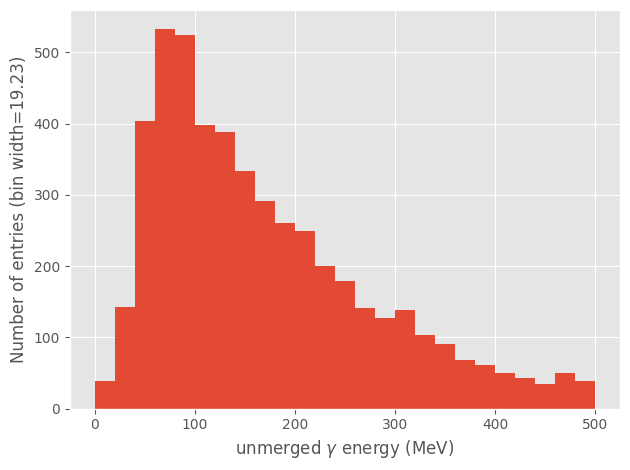

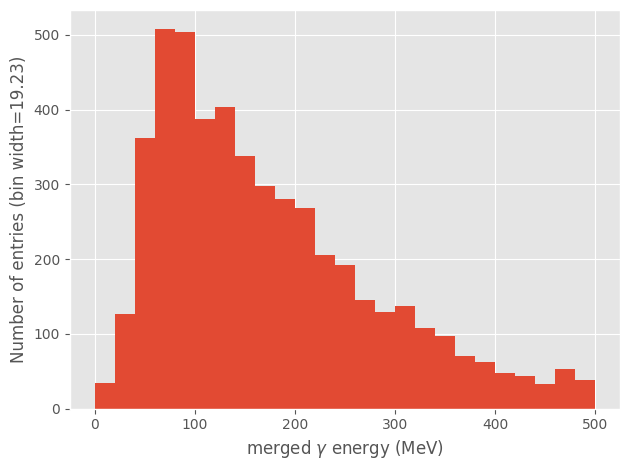

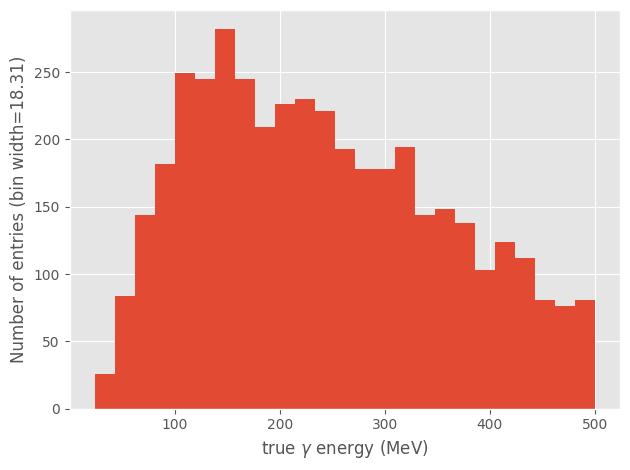

In [55]:
energy = {}
for d in data:
    energy[d] = np.concatenate([data[d].lead_energy, data[d].sub_energy])

[Plots.PlotHist(e[e <= 500], bins = 25, xlabel = k + " $\gamma$ energy (MeV)") for k, e in energy.items()]

In [56]:
def EnergyCorrection(energy):
    correction = -0.1114 + (-0.9051 - -0.1114)/(1 + np.power((energy)/ 0.06237, 1.496))
    return energy / (1 + correction)

def ComparisonPlot(e1, e2, l1, l2):
    x_range = [0, 1000]
    y_range = [0, 1000]

    x_mask = (e1 < max(x_range)) & (min(x_range) < e1)
    y_mask = (e2 < max(y_range)) & (min(y_range) < e2)

    x = e1[x_mask & y_mask]
    y = e2[x_mask & y_mask]

    m, b = np.polyfit(x, y, 1)
    print(m, b)

    m, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)
    print(m)

    Plots.PlotHist2D(x, y, bins = 50, xlabel = l1 + " energy (MeV)", ylabel = l2 + " energy (MeV)")
    x = np.linspace(0, 1000, 100)
    plt.plot(x, x, linestyle = "--")
    plt.plot(x, m * x, linestyle = "-", color = "purple")
    plt.xlim(x_range)
    plt.ylim(y_range)
    if save : Plots.Save(f"{l1}_vs_{l2}")

for c in itertools.combinations(energy.keys(), 2):
    ComparisonPlot(energy[c[1]], energy[c[0]], c[1], c[0])

ComparisonPlot(energy["true"], EnergyCorrection(energy["unmerged"]), "true", "MC driven correction")

0.9596731446494565 2.5813631583967545
[0.9683281]


/tmp/ipykernel_48483/1588303435.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)


0.5294187653361763 32.070946022497665
[0.61268012]
0.5381839185457595 34.069430785264345
[0.62662966]
0.5882438863669712 37.918263238622075
[0.68702197]


In [57]:
def FractionalEnergyPlot(reco_energy, title):
    Plots.PlotHist2D(energy["true"], (reco_energy / energy["true"]) - 1, bins = 50, y_range=(-1, 1), x_range = (0, 1200), xlabel = "True energy (MeV)", ylabel = "reco/true - 1", title = title)
    if save: Plots.Save("fractional_energy_" + title)

[FractionalEnergyPlot(energy[e], e) for e in ["unmerged", "merged"]]
FractionalEnergyPlot(1000 * EnergyCorrection(energy["unmerged"]/1000), "MC driven correction")

#? make residual plots or 1D error plots

In [58]:
def PlotMass(mass, tags, title):
    Plots.PlotHist(mass, stacked = True, color = tags.colour.values, label = tags.name.values, bins = 20, title  = title, xlabel = "$m_{\pi^{0}}$ (MeV)")
    plt.axvline(134.98, c = "red", linestyle = "--")
    plt.axvline(50 , c = "black")
    plt.axvline(250, c = "black")
    if save: Plots.Save("tagged_mass_" + title)

def CountMassCut(mass):
    return ak.sum((mass > 50) & (mass < 250))

tag_map = pd.read_hdf(file, "tag_map")
metadata = pd.read_hdf(file, "metadata")

tags = shower_merging.GenerateTruthTags()

for m in tag_map:
    if m == "not tagged": continue # ignore event topologies we aren't interested in
    tags[m].mask = metadata.tag == tag_map[m].values[0]

tables = {}

for d in ["unmerged", "merged"]:
    mass = [ak.ravel(data[d].mass[tags[tag].mask].values) for tag in tags]
    mass = [m[m < 500] for m in mass]
    PlotMass(mass, tags, d)

    t = {}
    print(d)
    for tag, m in zip(tags, mass):
        t[tags[tag].name] = CountMassCut(m)
    t["all"] = ak.sum( (data[d].mass.values > 50) & (data[d].mass.values < 250) )
    tables[d] = t

mass = [shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy[tags[tag].mask]), EnergyCorrection(data["unmerged"].sub_energy[tags[tag].mask]), data["unmerged"].angle[tags[tag].mask]) for tag in tags]
mass = [m[m < 500] for m in mass]

PlotMass(mass, tags, "MC driven correction")
t = {}
for tag, m in zip(tags, mass):
    t[tags[tag].name] = CountMassCut(m)

t["all"] = CountMassCut(shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy), EnergyCorrection(data["unmerged"].sub_energy), data["unmerged"].angle))

tables["MC driven correction"] = t

tables = pd.DataFrame(tables)

print(tables.to_latex())

purity = tables.loc["$1\pi^{0} + 0\pi^{+}$"]/tables.loc["all"]
print(tables)
print(purity)

unmerged
merged
\begin{tabular}{lrrr}
\toprule
{} &  unmerged &  merged &  MC driven correction \\
\midrule
\$\textbackslash geq 1\textbackslash pi\textasciicircum \{0\} + X\$        &       258 &     253 &                   239 \\
\$1\textbackslash pi\textasciicircum \{0\} + 0\textbackslash pi\textasciicircum \{+\}\$      &      1096 &    1105 &                  1099 \\
\$0\textbackslash pi\textasciicircum \{0\} + 0\textbackslash pi\textasciicircum \{+\}\$      &        32 &      32 &                    34 \\
\$1\textbackslash pi\textasciicircum \{0\} + \textbackslash geq 1\textbackslash pi\textasciicircum \{+\}\$ &       325 &     318 &                   311 \\
\$0\textbackslash pi\textasciicircum \{0\} + \textbackslash geq 1\textbackslash pi\textasciicircum \{+\}\$ &       202 &     198 &                   200 \\
all                        &      1921 &    1914 &                  1891 \\
\bottomrule
\end{tabular}

                            unmerged  merged  MC driven correction
$\

/tmp/ipykernel_48483/777626667.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tables.to_latex())


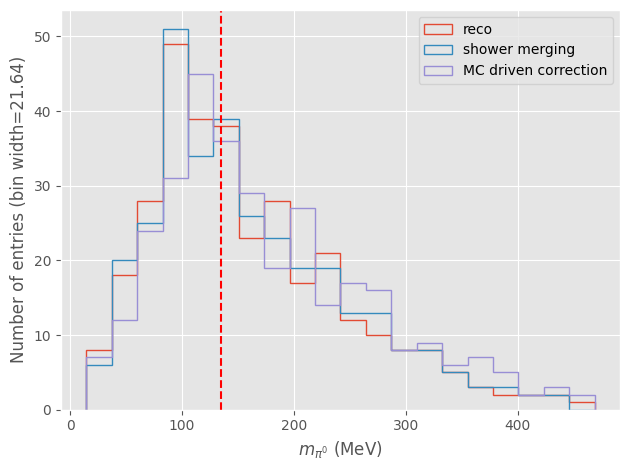

In [59]:
mask = tags.name_simple["inclusive signal"].mask

mass_signal = {
    "reco" : data["unmerged"].mass[mask].values,
    "shower merging" : data["merged"].mass[mask].values,
    "MC driven correction" : shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy[mask]), EnergyCorrection(data["unmerged"].sub_energy[mask]), data["unmerged"].angle[mask])
}

Plots.PlotHistComparison(list(mass_signal.values()), labels = list(mass_signal.keys()), bins = 20, xRange = [0, 500], xlabel = "$m_{\pi^{0}}$ (MeV)", density = False)
plt.axvline(134.98, c = "red", linestyle = "--")
